TODO before:

    Make sure both are optimised while using the same Best Estimate values of the static uncertainty
    Use those same Best Estimate values for here.

In [129]:
import pickle
import numpy as np
import pandas as pd

from geopy.distance import great_circle

import pygmo as pg

import matplotlib.pyplot as plt

import lib.pareto as pareto

In [2]:
from lib.fl_model_v9 import *

# Load Optimised Policies 

In [3]:
case = "Nepal"

## Load all policies proposed by dynamic uncertainty

In [4]:
output_folder = "infov3_4p"

In [5]:
with open('{}/{}/python_objects.pickle'.format(case, output_folder),
          'rb') as handle:
    global_label_tree, EMA_model_dict, global_dfs_var_unc_data, global_fixed_unc, global_policy_tree = pickle.load(
        handle)

In [6]:
p4_labels = global_label_tree['p4']

In [8]:
p4_pols = [global_policy_tree[label] for label in p4_labels]

In [9]:
p4_pols = np.array(p4_pols)

In [10]:
print("P4 after Multi-Period Robust Optimisation contains {} number of policies".format((p4_pols.shape)))

P4 after Multi-Period Robust Optimisation contains (1351,) number of policies


# Get Performance

## Set parameters of best estimates. Should be the same as used for 

In [11]:
Fix_Unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case), index_col=0)

DPs = pd.read_csv("Nepal/Prepared Input Data/DPs.csv")
# DPs.columns

FLs = pd.read_csv("Nepal/Prepared Input Data/FLs.csv")
# FLs.columns

SPs = pd.read_csv("Nepal/Prepared Input Data/SPs.csv")
# SPs.columns

# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}


In [12]:
Fix_Unc

,lower,best_estimate,upper
var,,,
unit_opening_costs,50.0,100,200
unit_transport_cost,0.5,1,2
FL_operations_cost,20.0,30,50
FL_range,2.0,4,6
demand_per_affected,10.0,20,50


In [13]:
print("Pick right Epicentre, or load disruption data")
print("TODO: Load disruption")

Pick right Epicentre, or load disruption data
TODO: Load disruption


In [14]:
epicentre_name = "RealLocation"

In [15]:
disruptionsFLs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionFL{}.txt'.format(epicentre_name))
disruptionsDPs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionDP{}.txt'.format(epicentre_name))

In [16]:
# Base real values on Nepal earthquake
# DSR is abbreviation for Disruption

DSRDP = {"DSRDP{}".format(i): disruptionsDPs[i] for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): disruptionsFLs[i] for i in range(len(FLX))}

## Evaluate DynamicUncPols under best estimates of static uncertainty

In [18]:
len(p4_pols)

1351

In [19]:
Dyn_Unc_best_est_results = []
for pol in p4_pols:
    Dyn_Unc_best_est_results.append(
        FL_model(
            unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
            FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **pol,
            **DSRDP,
            **DSRFL,
            **DPpop))

In [22]:
Dyn_Unc_best_est_results = np.array(Dyn_Unc_best_est_results)

In [28]:
Dyn_Unc_best_est_results

array([[118502.43098280455, 14, 10731.90413747319, 53409.11799336293,
        True, None],
       [121687.22201560512, 13, 10718.702545122338, 53409.11799336293,
        True, None],
       [272084.4154191506, 13, 10586.014422277876, 40806.74909473771,
        True, None],
       ...,
       [230370.18915833393, 12, 3224.469901353659, 45920.15739466251,
        True, None],
       [65253.881256298904, 19, 12666.797997925285, 45920.15739466251,
        True, None],
       [47386.75661875982, 21, 14245.85305828652, 59777.42, True, None]],
      dtype=object)

In [29]:
oois = [
        'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
        'max_travel_time'
    ]

In [34]:
testdf = Dyn_Unc_best_est_results

In [31]:
# plot 1 trade-off

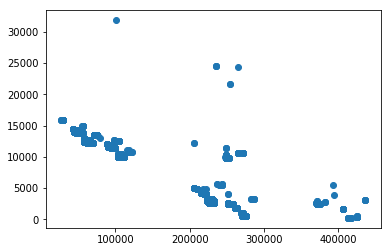

In [44]:
plt.scatter(testdf[:,0],testdf[:,2])

In [72]:
import seaborn as sns

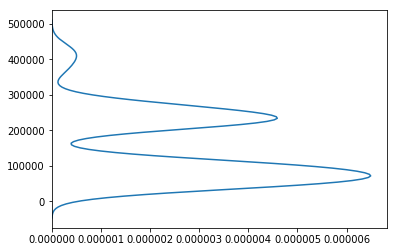

In [95]:
sns.kdeplot(testdf[:,0],vertical=True)

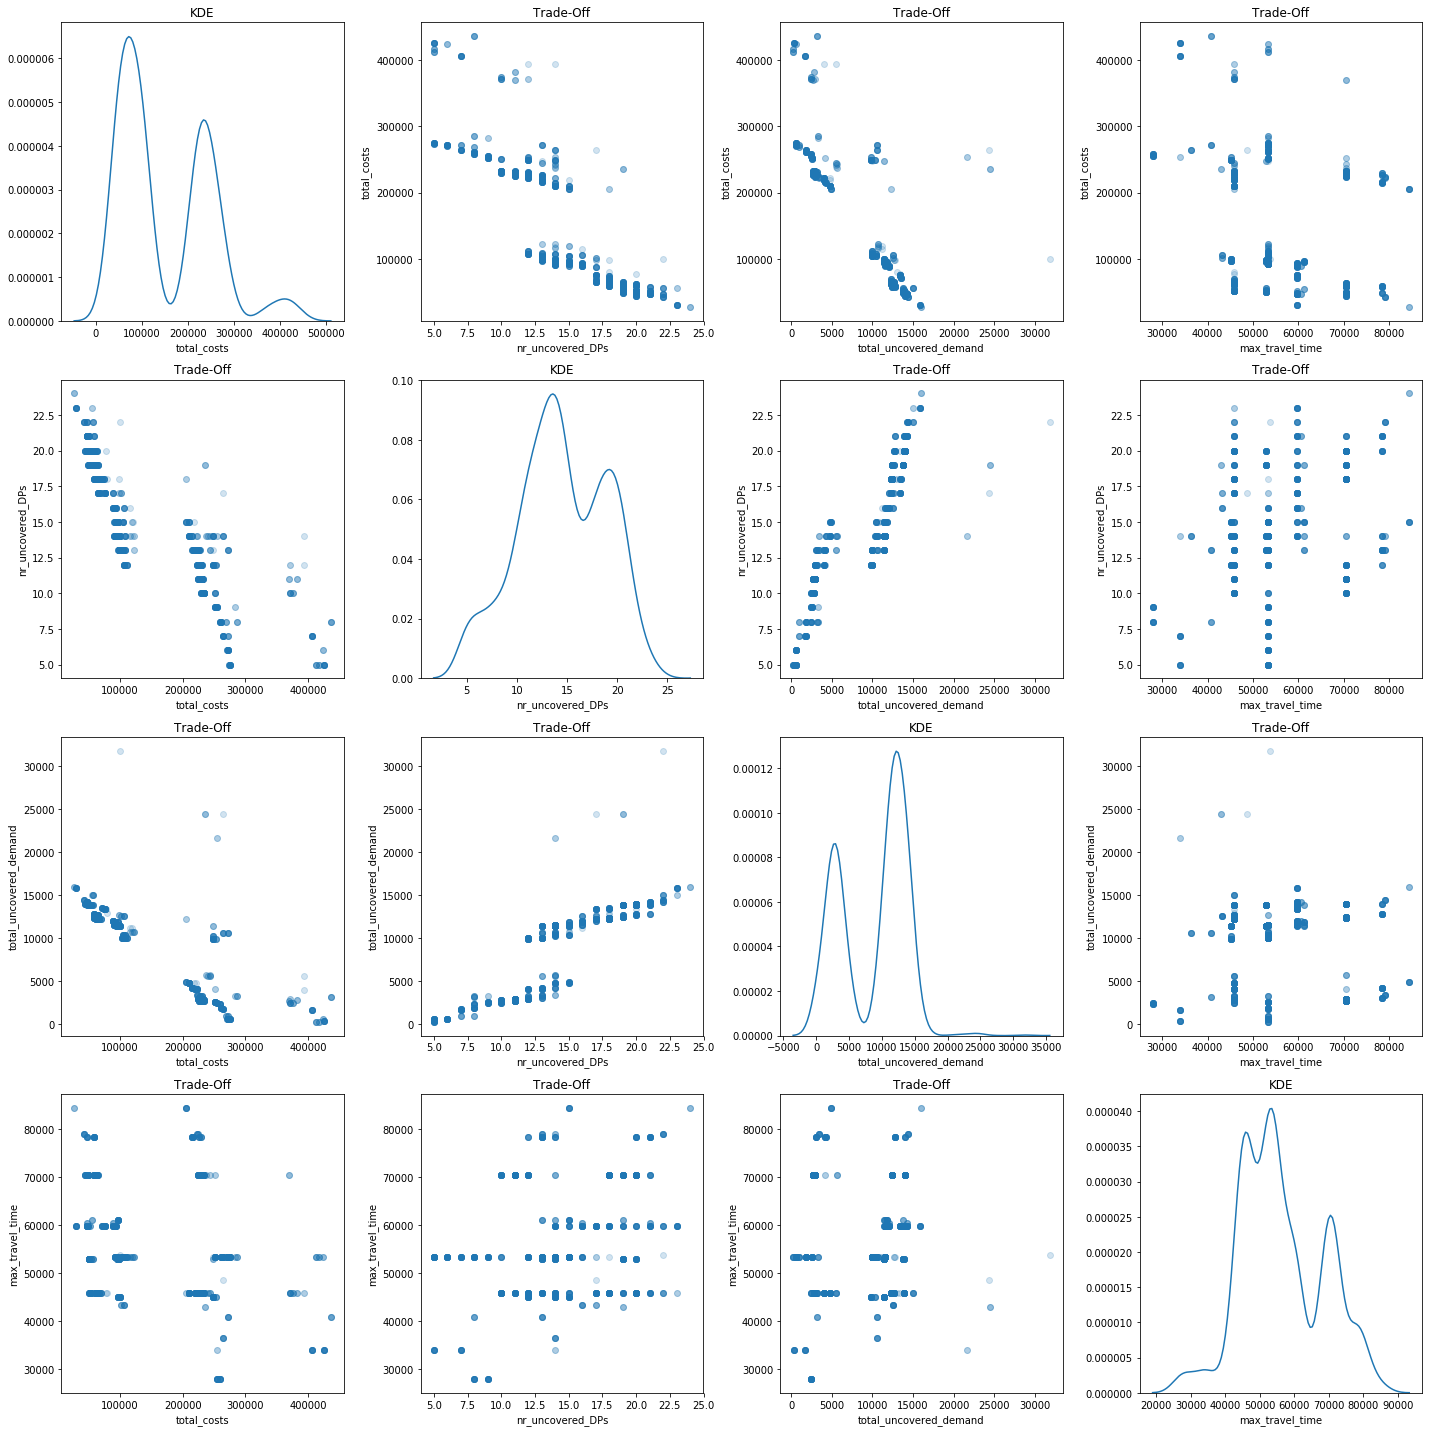

In [107]:
fig = plt.figure(figsize=(20,20))

position = 0
for i,ooi in enumerate(oois):
    for j,ooi2 in enumerate(oois):
        if i == j:
            ax = fig.add_subplot(4,4,position+1)
            sns.kdeplot(testdf[:,i], ax=ax)
            ax.set_title("KDE")
            ax.set_xlabel(oois[i])
            position+=1
            continue
        ax = fig.add_subplot(4,4,position+1)
        position +=1
        ax.scatter(testdf[:,j],testdf[:,i], alpha=0.2)
        ax.set_title("Trade-Off")
        ax.set_ylabel(oois[i])
        ax.set_xlabel(oois[j])
#         plt.show()
fig.tight_layout()
plt.show()

In [191]:
# fig = plt.figure(figsize=(20,20))

# position = 0
# for i,ooi in enumerate(oois):
#     for j,ooi2 in enumerate(oois):
#         if i == j:
# #             ax = fig.add_subplot(4,4,position+1)
# #             sns.kdeplot(testdf[:,i], ax=ax)
# #             ax.set_title("KDE")
# #             ax.set_xlabel(oois[i])
#             position+=1
#             continue
#         if j>i:
#             position+=1
#             continue
#         ax = fig.add_subplot(4,4,position+1)
#         position +=1
#         ax.scatter(testdf[:,j],testdf[:,i], alpha=0.2)
# #         ax.set_title("Trade-Off")
        
#         if j == 0:
#             ax.set_ylabel(oois[i],fontsize=20)
#         if i == 3:
#             ax.set_xlabel(oois[j], fontsize=20)
# #         plt.show()
# fig.tight_layout()
# plt.show()

## Do the same for the Pareto Front

In [128]:
test2 = pd.DataFrame(testdf[:,:4])

In [133]:
testPF = np.array(
    pareto.eps_sort(
        [list(test2.itertuples(index=True))],
        [1, 2, 3, 4], [1e-9, 1e-9, 1e-9, 1e-9]))

In [143]:
PFtest = testPF[:,1:]

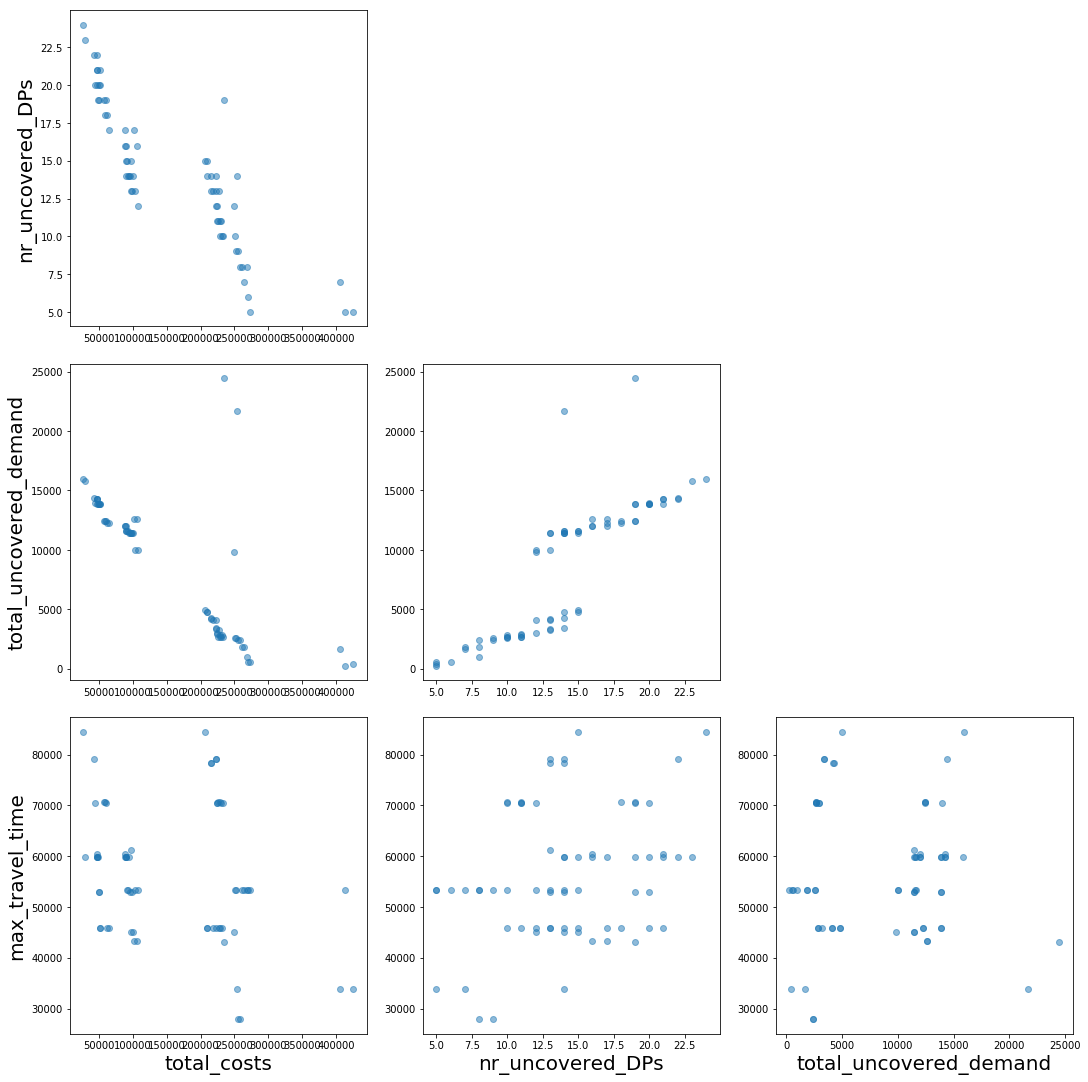

In [145]:
fig = plt.figure(figsize=(20,20))

position = 0
for i,ooi in enumerate(oois):
    for j,ooi2 in enumerate(oois):
        if i == j:
#             ax = fig.add_subplot(4,4,position+1)
#             sns.kdeplot(PFtest[:,i], ax=ax)
#             ax.set_title("KDE")
#             ax.set_xlabel(oois[i])
            position+=1
            continue
        if j>i:
            position+=1
            continue
        ax = fig.add_subplot(4,4,position+1)
        position +=1
        ax.scatter(PFtest[:,j],PFtest[:,i], alpha=0.5)
#         ax.set_title("Trade-Off")
        
        if j == 0:
            ax.set_ylabel(oois[i],fontsize=20)
        if i == 3:
            ax.set_xlabel(oois[j], fontsize=20)
#         plt.show()
fig.tight_layout()
plt.show()

# As parallel coordinate plot

In [170]:
import plotly.plotly as py
import plotly.graph_objs as go

In [157]:
df_PF = pd.DataFrame(PFtest)

In [159]:
df_PF.columns=oois

In [161]:
df_PF.head(2)

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_travel_time
0,254010.006208,14.0,21653.465661,33886.375193
1,103742.110580,13.0,10003.337274,53409.117993


<b>TODO: Add Robustness score as colour</b>

In [193]:
PLfig = [
    go.Parcoords(
        line=dict(color='blue'),
        dimensions=list([
            dict(
                #                 range = ,
                label=oois[0],
                values=df_PF[oois[0]]),
            dict(
                #                 range = ,
                label=oois[1],
                values=df_PF[oois[1]]),
            dict(
                #                 range = ,
                label=oois[2],
                values=df_PF[oois[2]]),
            dict(
                #                 range = ,
                label=oois[3],
                values=df_PF[oois[3]]),
            ###other dicts
        ]))
]

In [194]:
fig = go.Figure(data=PLfig)

In [195]:
plotly.offline.init_notebook_mode(connected=True)

In [196]:
plotly.offline.iplot(fig)